#**M_aug**

**Table of Contents**

1. [Overview](#Overview)
2. [Setup & Imports](#Setup-&-Imports)
3. [Data Loading and Preprocessing](#data-loading-and-preprocessing)
4. [Filter for Java Samples](#)
5. [Translating the Javacode samples](#Translating-the-Javacode-samples)
6. [Tokenization](#Tokenization)
7. [Training and Fine-Tuning](#Training-and-Fine-Tuning)
8. [Evaluation](#Evaluation)


This notebook features the fine-tuning of CodeBERT and the translation of Java code samples to C++. The model is designed to classify code changes into two labels:

0 – High quality, no further review required

1 – Low quality, requires additional review



In [ ]:
# Install required packages
!pip install datasets
!pip install -U transformers
!pip install --upgrade transformers
!pip install datasets --upgrade
!pip install openai
!pip install --upgrade openai
!pip install azure-core
!pip install matplotlib pandas
!pip install evaluate

## **Setup & Imports**

In [ ]:
# Import libraries
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments , EarlyStoppingCallback
from datasets import load_dataset , concatenate_datasets, DatasetDict , Dataset
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score , confusion_matrix , classification_report
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
import warnings
from tqdm import tqdm
from openai import AzureOpenAI
from azure.core.credentials import AzureKeyCredential
warnings.filterwarnings('ignore')
import evaluate

## **Data Loading and Preprocessing**

- Load the dataset from Hugging Face.
- Filter the dataset to retain only Java samples.
- Combine the original code (`oldf`) and the corresponding (`patch`) into a unified field, `code_change`, representing the complete code change.


In [ ]:
# Load dataset from Hugging Face
train_ds = load_dataset("fasterinnerlooper/codereviewer", "train_quality")


In [ ]:
# Remove unnecessary columns not needed for training or evaluation
train_ds = train_ds.remove_columns(['msg','id','idx','proj'])


**Filter for Java Samples**
To build a language-specific dataset for Java, we apply two filtering strategies:

- For `y = 0`: Use the existing `lang == 'java'` metadata.
- For `y = 1`: Use a heuristic function (`is_java`) that detects Java -like syntax based on keyword patterns.

In [ ]:
# Filter the datasets to keep only C++ samples
train_ds_java = train_ds.filter(lambda example: example['lang'] == 'java')
train_ds_null_lang = train_ds.filter(lambda ex: ex["lang"] is None)

In [ ]:
#special Java kewords
java_keywords = [ "System.out.println",
    "implements",
    "extends",
    "package",
    "import java.",
    "@Override",
    "throws",
    "new Scanner(",
    "public static void main(String[] args)"
    "interface",
    "enum",
    "@FunctionalInterface",
    "@SuppressWarnings",
    "synchronized",
    "final",
    "transient",
    "volatile",
    "strictfp",
    "String",
    "Integer",
    "Double",
    "Boolean",
    "ArrayList",
    "HashMap",
    "LinkedList",
    "HashSet",
    "TreeMap",
    "java.util.",
    "java.io.",
    "java.lang.",
    "java.time.",
    "Scanner",
    "BufferedReader",
    "InputStreamReader",
    "FileWriter",
 ]

In [ ]:
def is_java(code: str) -> bool:

    """
    Analyze the source code to determine if it resembles java code.
    This function evaluates the provided string by searching for a predefined set
    of java keywords.
    If at least two such keywords are present, the code is considered
    to exhibit characteristics of java.

    Parameters
    ----------
    code : str
        The input source code as a single string.

    Returns
    -------
    bool
        True if two or more java keywords are found; otherwise, False.
    """

    count = sum(1 for kw in java_keywords if kw in code)
    return count >= 5

In [ ]:
java_labeled_samplesY1 = train_ds_null_lang.filter(
    lambda ex: ex['y'] == 1 and is_java(ex['oldf'])
)

In [ ]:

# === Java Training Dataset Preparation ===

# Extract the 'train' splits from both labeled datasets:
# - java_train_0: Java samples with label y=0 (high quality)
# - java_train_1: Java samples with label y=1 (low quality)


java_train_0 = train_ds_java['train']
java_train_1 = java_labeled_samplesY1['train']
print("y=1",len(java_train_1))
print("y=0",len(java_train_0))


# Select up to 600 samples from each label to ensure a balanced dataset.
java_train_0_sampled = java_train_0.select(range(min(600, len(java_train_0))))
java_train_1_sampled = java_train_1.select(range(min(600, len(java_train_1))))
print("y=1",len(java_train_1_sampled))
print("y=0",len(java_train_0_sampled))

# Combine both subsets into a single dataset
combined_java_train = concatenate_datasets([java_train_0_sampled, java_train_1_sampled])

# Shuffle the combined dataset to randomize the order of examples.
combined_java_train = combined_java_train.shuffle(seed=42)


from collections import Counter
print(Counter(combined_java_train['y']))

y=1 20343
y=0 18988
y=1 2000
y=0 2000
Counter({0: 2000, 1: 2000})


In [ ]:
train_dataset_java = DatasetDict({
    'train': combined_java_train
})


y1_examples = train_dataset_java['train'].filter(lambda ex: ex['y'] == 1)
print(f"Number of examples with y=1: {len(y1_examples)}")

### **Extract Diff with Context**

To capture code changes with surrounding context, we extract:

- Modified lines from `patch` (additions and deletions)  
- `context_lines` before and after each change  

Lines are annotated as:

- `[ADD]` for added lines  
- `[DEL]` for deleted lines  

Metadata (e.g., `+++`, `---`, `@@`) is removed to keep the output clean.

In [ ]:
def extract_diff_with_context(old_code: str, patch: str, context_lines: int ) -> str:

    """
    Extracts code changes from a unified diff (`patch`) along with surrounding context lines.

    Parameters:
    ----------
    old_code : str
        Original code before the changes (not used in processing, but retained for interface consistency).

    patch : str
        Unified diff string representing the code changes.

    context_lines : int, optional (default=5)
        Number of lines to include before and after each change for contextual understanding.

    Returns:
    -------
    str
        A formatted string containing:
        - Context lines around each change
        - `[ADD]`-prefixed lines for additions
        - `[DEL]`-prefixed lines for deletions
        - Excludes non-informative diff metadata (e.g., '+++', '---', '@@')

    Example output:
        some unchanged line
        [DEL] removed line
        [ADD] added line
        another unchanged line
    """

    patch_lines = patch.splitlines()
    context_indices = set()

    for i, line in enumerate(patch_lines):
        if line.startswith(('+', '-')) and not line.startswith(('+++', '---')):
            start = max(0, i - context_lines)
            end = min(len(patch_lines), i + context_lines + 1)
            context_indices.update(range(start, end))

    extracted_lines = []
    for i in sorted(context_indices):
        line = patch_lines[i]
        if line.startswith(('@@', '+++', '---')):
            continue
        if line.startswith('+') and not line.startswith('+++'):
            line = '[ADD] ' + line[1:].strip()
        elif line.startswith('-') and not line.startswith('---'):
            line = '[DEL] ' + line[1:].strip()
        extracted_lines.append(line)

    return "\n".join(extracted_lines)

In [ ]:
def apply_extract_diff(example, context_lines=3):
    # Extract diff with context for each example row
    return {
        "extracted_diff": extract_diff_with_context(
            example["oldf"], example["patch"], context_lines=context_lines
        )
    }

In [ ]:
def print_diff_examples(dataset, num_examples, context_lines):

    """
    Print a few examples from the dataset showing the original code, the patch,
    and the extracted diff with context.

    Parameters:
    ----------
        dataset: Each item should have 'oldf' and 'patch'.
        num_examples (int): Number of examples to print.
        context_lines (int): Number of context lines to include.
    """

    for i in range(num_examples):
        example = dataset[i]
        old_code = example.get('oldf', '')
        patch = example.get('patch', '')
        extracted = extract_diff_with_context(old_code, patch, context_lines=context_lines)

        print(f"Example {i + 1}")
        print(extracted)
        print("=" * 60, "\n")

In [ ]:
print_diff_examples(train_dataset_java['train'], 3, 3)

Example 1
           + " for defining a delegate runner to be used.");
     }
 
[DEL] if (pluginClassLoaders != null && !pluginClassLoaders.isEmpty()) {
[DEL] builders.add(0, new IsolatedClassLoaderExtensionsManagerConfigurationBuilder(pluginClassLoaders));
[ADD] if (artifactClassLoaderHolderAdapter != null
[ADD] && !artifactClassLoaderHolderAdapter.getPluginsArtifactClassLoaders().isEmpty()) {
[ADD] builders.add(0, new IsolatedClassLoaderExtensionsManagerConfigurationBuilder(artifactClassLoaderHolderAdapter
[ADD] .getPluginsArtifactClassLoaders()));
     }
   }
[DEL] 
 }

Example 2
  */
 public class SpillableMapBasedFileSystemView extends HoodieTableFileSystemView {
 
[DEL] private static final Logger LOG = LogManager.getLogger(SpillableMapBasedFileSystemView.class);
[ADD] private static final Logger LOG = LoggerFactory.getLogger(SpillableMapBasedFileSystemView.class);
 
   private final long maxMemoryForFileGroupMap;
   private final long maxMemoryForPendingCompaction;

Example 3
 i

In [ ]:
train_ds_java = train_dataset_java.map(
    apply_extract_diff,
    batched=False,
    remove_columns=None
)

In [ ]:
def count_words_batch(examples):
    return {'word_count': [len(text.split()) for text in examples['extracted_diff']]}

In [ ]:
train_ds_java = train_ds_java.map(count_words_batch, batched=True)


In [ ]:
def count_examples_within_word_limit(dataset_split, word_limit=512):
    """
    Count how many examples in a dataset split have word counts within the given limit.

    Parameters:
    -----------
    dataset_split : Dataset
        A Hugging Face Dataset split (e.g., train_ds_java['train']).
        Assumes it has a 'word_count' field.

    word_limit : int, optional (default=512)
        Maximum number of words allowed to be counted as 'within limit'.

    Prints:
    -------
    Number and percentage of examples with word counts <= word_limit.
    """
    word_counts = dataset_split['word_count']
    total = len(word_counts)
    num_within_limit = sum(1 for wc in word_counts if wc <= word_limit)

    print(f"Examples with ≤ {word_limit} words: {num_within_limit} out of {total}")
    print(f"Percentage: {num_within_limit / total * 100:.2f}%")


In [ ]:
count_examples_within_word_limit(train_ds_java['train'])


Examples with ≤ 512 words: 3924 out of 4000
Percentage: 98.10%


Checking that the data set contains both y=0 and y=1 examples and deleting unneccery columns.

In [ ]:
y1_examples = train_ds_java['train'].filter(lambda ex: ex['y'] == 1)
print(f"Number of examples with y=1: {len(y1_examples)}")
print(train_ds_java['train'].column_names)

# Remove unnecessary columns: 'oldf', 'word_count', and 'lang'
# These columns are assumed to be irrelevant for the current task or already processed.
train_ds_java['train'] = train_ds_java['train'].remove_columns(['oldf', 'word_count', 'lang'])
print(train_ds_java['train'].column_names)



## **Translating the Java code samples**

In order the code to work you need to insert an  API key and endpoint.

In [ ]:
# Initialize an AzureOpenAI client for accessing the deployed language model
client = AzureOpenAI(
    api_key="YOUR API KEY",
    api_version="",
    azure_endpoint=""
)

In [ ]:
def translate_java_to_cpp(java_code: str, client, deployment_name="gpt-4.1"):
    """
    Translates a given Java code diff into idiomatic C++ using an OpenAI-compatible client (e.g., Azure or OpenAI SDK).

    The function sends a structured prompt to a language model (e.g., GPT-4.1) instructing it to:
    - Translate only the relevant changes in the Java code
    - Avoid adding unnecessary boilerplate code such as includes or full class definitions
    - Preserve the structure and intent of the original code
    - Exclude unchanged lines or auxiliary helper functions unless strictly necessary

    Parameters
    ----------
    java_code : str
        The Java code diff (textual format) that should be translated to C++.

    client : object
        A client instance for accessing the chat completion API (e.g., AzureOpenAI or OpenAI Python SDK).

    deployment_name : str, optional (default="gpt-4.1")
        The name of the deployed model to use for translation (can refer to a custom deployment or model version).

    Returns
    -------
    str
        A string containing the translated C++ code, with unnecessary parts removed and structure preserved.
    """
    prompt = f"""Translate only the relevant Java code changes to idiomatic C++.
Do not add boilerplate code (e.g., includes, full class definitions, or mocks).
Do not include unchanged lines or helper functions unless strictly necessary.
Preserve structure and intent faithfully.

Java diff:
{java_code}

C++ translation:"""

    response = client.chat.completions.create(
        model=deployment_name,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that translates Java code to idiomatic C++."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=512
    )

    return response.choices[0].message.content.strip()



In [ ]:
samples = train_ds_java['train']
translated_rows = []

# Iterate over each example with a progress bar
for i, ex in enumerate(tqdm(samples, desc="Translating")):
    java_diff = ex['extracted_diff']
    java_patch = ex['patch']

    try:
        cpp_diff = translate_java_to_cpp(java_diff, client, deployment_name="gpt-4.1")
    except Exception:
        cpp_diff = "ERROR"

    try:
        cpp_patch = translate_java_to_cpp(java_patch, client, deployment_name="gpt-4.1")
    except Exception:
        cpp_patch = "ERROR"  # In case of failure, store "ERROR"

# Append the original and translated fields to the results list
    translated_rows.append({
        "extracted_diff": java_diff,
        "cppex": cpp_diff,
        "patch": java_patch,
        "patch_cpp": cpp_patch,
        "y": ex["y"]
    })


df = pd.DataFrame(translated_rows)
df.to_csv("cpp_translations.csv", index=False)



In [ ]:
'''Steps:
1. Load the original dataset from 'cpp_translations.csv'.
2. Filter out rows where either 'cppex' or 'patch_cpp' is marked as "ERROR".
3. Drop unused columns: 'extracted_diff' and 'patch'.
4. Save the cleaned dataset to 'cpp_translations_final.csv'.
5. Print summary statistics about removed rows and file creation.'''

df = pd.read_csv("cpp_translations.csv")


original_len = len(df)
df_filtered = df[(df["cppex"] != "ERROR") & (df["patch_cpp"] != "ERROR")]
filtered_len = len(df_filtered)

#Deleting the redundent columns
df_filtered = df_filtered.drop(columns=["extracted_diff", "patch"])


df_filtered.to_csv("cpp_translations_final.csv", index=False)

print(f"file saved cpp_translations_final.csv")
print(f"deleted {original_len - filtered_len} lines with an Eror in the translation ")

**Class Distribution**

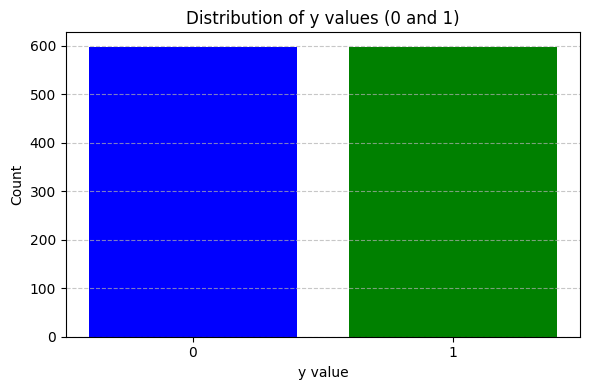

In [ ]:

df = pd.read_csv("cpp_translations_final.csv")

value_counts = df["y"].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(value_counts.index.astype(str), value_counts.values, color=["blue", "green"])  # שינוי צבעים כאן
plt.xlabel("y value")
plt.ylabel("Count")
plt.title("Distribution of y values (0 and 1)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



**Splitting the data set**

In [ ]:
df = pd.read_csv("cpp_translations_final.csv")
df = df.rename(columns={"y": "labels"})


In [ ]:
dataset = Dataset.from_pandas(df)
print(dataset.column_names)


['cppex', 'patch_cpp', 'labels']


In [ ]:
train_val_test = dataset.train_test_split(test_size=0.2, seed=42)
train_valid = train_val_test["train"].train_test_split(test_size=0.18, seed=42)

train_ds = train_valid["train"]
val_ds = train_valid["test"]
test_ds = train_val_test["test"]

**Training and Fine-Tuning**

In [ ]:
# Initialize the tokenizer
# Load and modify the config with custom dropout
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModelForSequenceClassification.from_pretrained("microsoft/codebert-base", num_labels=2)


special_tokens_dict = {'additional_special_tokens': ['[ADD]', '[DEL]']}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

In [ ]:
def tokenize_function(examples, tokenizer, max_length=512):
    combined_code = [f"{before}\n{after}" for before, after in zip(examples["cppex"], examples["patch_cpp"])]
    tokenized = tokenizer(
        combined_code,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors=None
    )
    tokenized["labels"] = examples["labels"]
    return tokenized

In [ ]:
def tokenize_function(examples, tokenizer, max_length=512):
    """
    Tokenizes C++ code diffs from 'cppex' and 'patch_cpp' fields that already include [DEL] and [ADD] markers.

    Parameters
    ----------
    examples : dict
        A dictionary containing:
        - 'cppex' : list of str
            Original C++ code diff (with [DEL] markers).
        - 'patch_cpp' : list of str
            Modified C++ code diff (with [ADD] markers).
        - 'labels' : list of int
            Class labels for each example.

    tokenizer : PreTrainedTokenizer
        A Hugging Face tokenizer including [ADD], [DEL] tokens.

    max_length : int, optional (default=512)
        Max token sequence length.

    Returns
    -------
    dict
        Tokenized input_ids, attention_mask, and labels.
    """

    combined_code = [
        f"{before}\n{after}" for before, after in zip(examples["cppex"], examples["patch_cpp"])
    ]

    tokenized = tokenizer(
        combined_code,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors=None
    )

    tokenized["labels"] = examples["labels"]
    return tokenized

In [ ]:

train_ds = train_ds.map(tokenize_function, batched=True, batch_size=32, fn_kwargs={"tokenizer": tokenizer}, remove_columns=train_ds.column_names)
val_ds   = val_ds.map(tokenize_function, batched=True, batch_size=32, fn_kwargs={"tokenizer": tokenizer}, remove_columns=val_ds.column_names)
test_ds  = test_ds.map(tokenize_function, batched=True,  batch_size=32,fn_kwargs={"tokenizer": tokenizer}, remove_columns=test_ds.column_names)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",             # Directory to save checkpoints
    overwrite_output_dir=True,          # Overwrite output directory if exists
    eval_strategy="steps",              # Evaluate every eval_steps
    per_device_train_batch_size=32,     # Batch size for training
    per_device_eval_batch_size=32,      # Batch size for evaluation
    num_train_epochs=10,                # Train for 10 epochs
    logging_steps=10,                   # Log every 100 steps
    eval_steps=10,                      # Evaluate every 100 steps
    save_steps=100,                     # Save checkpoint every 100 steps
    save_total_limit=3,                 # Keep only the 3 latest checkpoints
    load_best_model_at_end=True,        # Load best model at end
    metric_for_best_model="f1",         # Use F1 to choose best model
    greater_is_better=True,             # Higher F1 is better
    fp16=True,                          # Use mixed precision
    learning_rate=1e-5,                 # learning rate
    weight_decay=0.01,                  # Weight decay for regularization
    warmup_ratio=0.1,                   # Warmup 10% steps
    gradient_accumulation_steps=4,      # Gradient accumulation
    dataloader_num_workers=4,           # More workers for data loading
    logging_dir="./logs",               # TensorBoard logs
    seed=42,                            # Seed for reproducibility
    label_smoothing_factor=0.1,         # Helps prevent overconfidence by slightly softening the target labels (e.g., instead of 1.0 use 0.9)
    logging_strategy="steps",           # Specifies that logging should happen every fixed number of steps during training
    report_to="none"                    # Disables reporting to external logging tools (like TensorBoard, Weights & Biases, etc.)

)


In [ ]:
def compute_metrics(eval_pred) -> dict:

    """
    Computes evaluation metrics based on model predictions and true labels.

    Parameters
    ----------
    eval_pred : tuple
        A tuple containing logits (np.ndarray) and true labels (np.ndarray).

    Returns
    -------
    dict
        A dictionary with accuracy, F1 score, precision, and recall (all weighted).
    """

    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted'),
        'precision': precision_score(labels, preds, average='weighted'),
        'recall': recall_score(labels, preds, average='weighted')
    }

In [ ]:
# Set up the trainer to train the model with class weights, evaluation, and early stopping.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,0.648500,0.681571,0.473988,0.317409,0.753913,0.473988
20,0.622900,0.638941,0.641618,0.635902,0.641473,0.641618
30,0.539100,0.606684,0.670520,0.652538,0.689943,0.670520
40,0.576000,0.621395,0.664740,0.664583,0.673196,0.664740
50,0.514500,0.608312,0.670520,0.670917,0.674946,0.670520
60,0.551400,0.611995,0.676301,0.675326,0.689225,0.676301
70,0.510100,0.614999,0.664740,0.662516,0.682370,0.664740


TrainOutput(global_step=70, training_loss=0.5660652569362096, metrics={'train_runtime': 187.278, 'train_samples_per_second': 41.81, 'train_steps_per_second': 0.374, 'total_flos': 2060159563468800.0, 'train_loss': 0.5660652569362096, 'epoch': 10.0})

**Evaluation**

In [ ]:
trainer.evaluate()


{'eval_loss': 0.6149994134902954,
 'eval_accuracy': 0.6647398843930635,
 'eval_f1': 0.6625158994396271,
 'eval_precision': 0.6823698623795361,
 'eval_recall': 0.6647398843930635,
 'eval_runtime': 1.5043,
 'eval_samples_per_second': 115.005,
 'eval_steps_per_second': 3.989,
 'epoch': 10.0}

In [ ]:
logs = trainer.state.log_history

train_steps = [log["step"] for log in logs if "loss" in log]
train_losses = [log["loss"] for log in logs if "loss" in log]

val_steps = [log["step"] for log in logs if "eval_loss" in log]
val_losses = [log["eval_loss"] for log in logs if "eval_loss" in log]

In [ ]:
logs = trainer.state.log_history
print(logs)

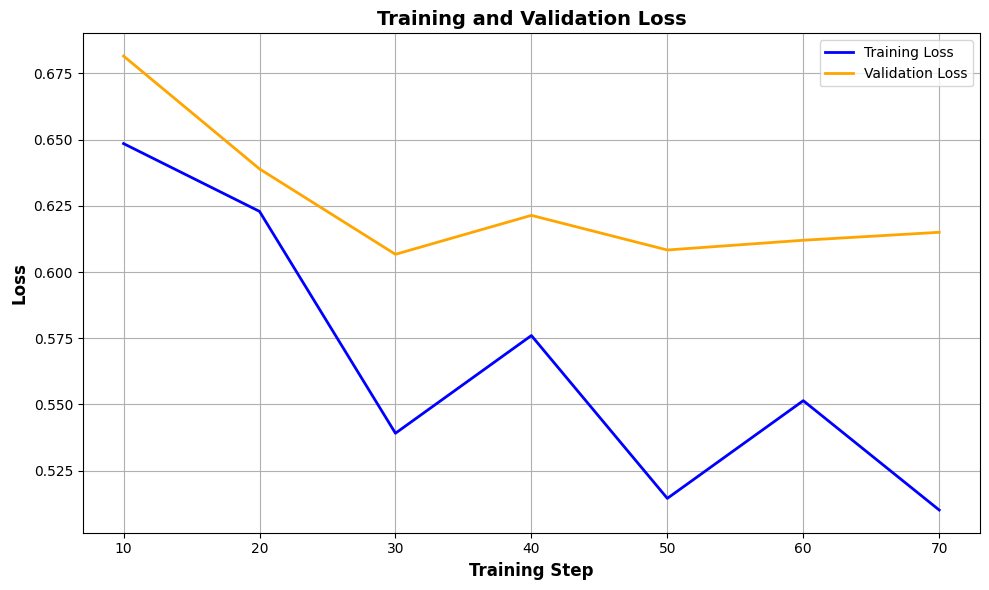

In [ ]:
plt.figure(figsize=(10, 6))

# Plot the training loss curve
plt.plot(train_steps, train_losses, label="Training Loss", color="blue", linewidth=2)

# Plot the validation loss curve
plt.plot(val_steps, val_losses, label="Validation Loss", color="orange", linewidth=2)


plt.xlabel("Training Step", fontsize=12, fontweight='bold')
plt.ylabel("Loss", fontsize=12, fontweight='bold')
plt.title("Training and Validation Loss", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

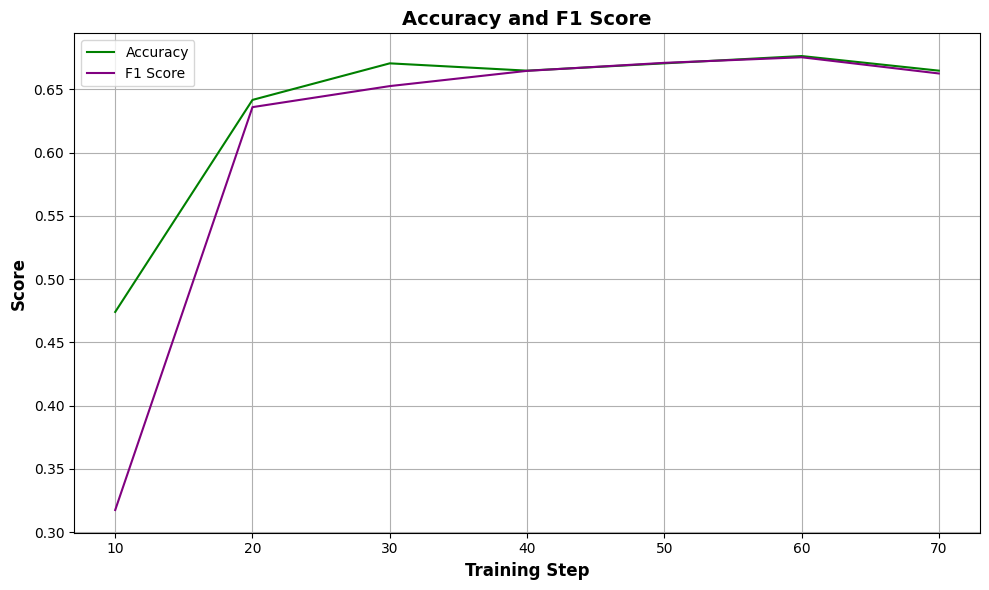

In [ ]:
# Accuracy
acc_steps = [log["step"] for log in logs if "eval_accuracy" in log]
acc_scores = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]

# F1
f1_steps = [log["step"] for log in logs if "eval_f1" in log]
f1_scores = [log["eval_f1"] for log in logs if "eval_f1" in log]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(acc_steps, acc_scores, label="Accuracy", color="green")
plt.plot(f1_steps, f1_scores, label="F1 Score", color="purple",)

plt.xlabel("Training Step",fontsize=12,fontweight='bold')
plt.ylabel("Score",fontsize=12,fontweight='bold')
plt.title("Accuracy and F1 Score",fontsize=14,fontweight='bold')
plt.legend()
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Loads and prepares a real-world (non-synthetic) C++ evaluation dataset for model testing.**

Steps:
1. Load the 'test_quality' and 'validation_quality' splits from the 'fasterinnerlooper/codereviewer' dataset.
2. Extract the 'train' portion of each split (these contain the actual labeled examples).
3. Remove metadata columns that are not needed for model evaluation: 'msg', 'id', 'idx', 'proj'.
4. Filter the datasets to include only examples where the programming language is 'cpp'.
5. Concatenate both filtered datasets into a single C++ evaluation dataset.

This combined dataset represents real, non-synthetic C++ code examples,
and is used to evaluate the model's performance on realistic code changes.

In [ ]:

test_ds = load_dataset("fasterinnerlooper/codereviewer", "test_quality")["train"]
val_ds = load_dataset("fasterinnerlooper/codereviewer", "validation_quality")["train"]

val_ds = val_ds.remove_columns(['msg', 'id', 'idx', 'proj'])
test_ds = test_ds.remove_columns(['msg', 'id', 'idx', 'proj'])

val_ds_cpp = val_ds.filter(lambda example: example['lang'] == 'cpp')
test_ds_cpp = test_ds.filter(lambda example: example['lang'] == 'cpp')

combined_cpp = concatenate_datasets([val_ds_cpp, test_ds_cpp])




In [ ]:
combined_cpp = combined_cpp.map(
    apply_extract_diff,
    batched=False,
    remove_columns=None
)

In [ ]:
# Function to preprocess the dataset: renames fields to standard names

def preprocess_cpp_dataset(dataset):
    return dataset.map(lambda example: {
        "cppex": example["oldf"],
        "patch_cpp": example["patch"],
        "labels": example["y"]
    })

# Apply preprocessing to the combined C++ dataset
prepared_ds = preprocess_cpp_dataset(combined_cpp)

# Tokenize the preprocessed dataset using the provided tokenizer
tokenized_ds = prepared_ds.map(lambda x: tokenize_function(x, tokenizer), batched=True)


In [ ]:
# Evaluate the model's performance on the tokenized evaluation dataset
results = trainer.evaluate(eval_dataset=tokenized_ds)
print(results)

{'eval_loss': 0.7098334431648254, 'eval_accuracy': 0.5994777215603069, 'eval_f1': 0.5900772760794469, 'eval_precision': 0.5865602320629285, 'eval_recall': 0.5994777215603069, 'eval_runtime': 37.4486, 'eval_samples_per_second': 163.611, 'eval_steps_per_second': 5.127, 'epoch': 10.0}


In [ ]:
predictions = trainer.predict(tokenized_ds)


logits = predictions.predictions
y_true = predictions.label_ids
y_pred = np.argmax(logits, axis=1)


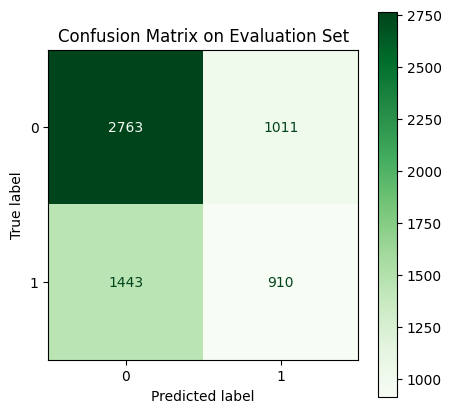

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap="Greens", ax=ax)
plt.title("Confusion Matrix on Evaluation Set")
plt.show()